This notebook is intended to explore the gaussian regressors on 1.1.3.15 data.<br/><br/>Copyright (C) 2019  Martin Engqvist Lab<br/>This program is free software: you can redistribute it and/or modify<br/>it under the terms of the GNU General Public License as published by<br/>the Free Software Foundation, either version 3 of the License, or<br/>(at your option) any later version.<br/>This program is distributed in the hope that it will be useful,<br/>but WITHOUT ANY WARRANTY; without even the implied warranty of<br/>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br/>GNU General Public License for more details.<br/>You should have received a copy of the GNU General Public License<br/>along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = 'similarity_data'
if folder_name != '':
#     #make folders if they don't exist
#     if not exists(join(RAW_EXTERNAL, folder_name)):
#         os.makedirs(join(RAW_EXTERNAL, folder_name))

#     if not exists(join(INTERMEDIATE, folder_name)):
#         os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

Standard variables loaded, you are good to go!


In [66]:
import pickle
import os
import subprocess

import pandas as pd
import numpy as np
import scipy
from scipy import stats

from Bio import SeqIO
from collections import Counter

from sklearn import metrics
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.manifold import TSNE, MDS
from sklearn.model_selection import LeaveOneOut

from sklearn.model_selection import KFold # import KFold

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import DotProduct, ExpSineSquared, Exponentiation, WhiteKernel 

from gpmodel import gpmodel, gpkernel, chimera_tools

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# import tsne
import sys; sys.path.append('/home/localadmin/github/FIt-SNE')
from fast_tsne import fast_tsne

#### Load feature data from UniRep Fusion

In [184]:
# load data and drop duplicates
filepath = join(INTERMEDIATE, '1.1.3.n_test_data', '1_1_3__BRENDA_sequences_filtered_unirep.csv')
unirep = pd.read_csv(filepath, sep=',')

# replace the first column with identifiers
unirep['Unnamed: 0'] = [i.split(';')[0] for i in unirep['Unnamed: 0']]


# re-name column
unirep = unirep.rename(columns={'Unnamed: 0':'uid'}).drop_duplicates()

# load uid to ec mapping and merge with property data
filepath = join(FINAL, 'BRENDA', 'ec_uid_org_from_fasta.tsv')
uid_ec = pd.read_csv(filepath, sep='\t').drop_duplicates()

# merge and keep only ec 1.1.3.15
unirep_merged = unirep.merge(uid_ec, on='uid')
df_unirep = unirep_merged[unirep_merged.ec=='1.1.3.15'].drop('ec', axis=1)

display(df_unirep.head())
display(df_unirep.tail())
display(df_unirep.shape)

,uid,av_1,av_2,av_3,av_4,av_5,av_6,av_7,av_8,av_9,...,fc_1891,fc_1892,fc_1893,fc_1894,fc_1895,fc_1896,fc_1897,fc_1898,fc_1899,fc_1900
33,Q9LRS0,0.015368,0.207102,0.076687,-0.040839,-0.116888,0.069290,0.011434,-0.046359,-0.004900,...,0.314290,0.790594,-0.073425,0.092050,-2.026679,-0.509705,0.087245,-1.506297,0.134522,0.133363
34,Q9NYQ3,0.008693,0.174844,0.069413,-0.042212,-0.134430,0.074950,0.001461,-0.043215,-0.005424,...,0.089248,-0.263056,-0.042254,1.496964,-5.197632,-0.705789,0.733266,-2.503108,0.237560,0.250488
35,P37339,0.024516,0.012727,0.070110,-0.008737,-0.356430,0.079727,-0.072076,0.021245,-0.004387,...,0.002008,-0.151272,-0.355467,0.982859,-12.764019,0.079447,0.277420,-0.994416,0.123665,4.128018
36,Q24JJ8,0.011160,0.157242,0.094497,-0.049337,-0.101914,0.079308,0.020020,-0.047959,-0.003755,...,0.467036,0.284700,-0.034987,0.619065,0.641811,-1.148384,-0.318679,-2.219294,0.175719,0.342886
37,B8AUI3,0.015618,0.195817,0.077877,-0.038937,-0.114840,0.062852,0.023076,-0.044319,-0.004918,...,0.174403,-0.260183,-0.017469,0.329009,-3.487079,-0.563793,-1.393169,-1.276244,0.272283,-0.236024


,uid,av_1,av_2,av_3,av_4,av_5,av_6,av_7,av_8,av_9,...,fc_1891,fc_1892,fc_1893,fc_1894,fc_1895,fc_1896,fc_1897,fc_1898,fc_1899,fc_1900
1439,D5MNA0,0.005720,0.144893,0.087827,-0.028350,-0.115191,0.140921,0.024286,-0.015941,-0.004543,...,-0.699620,-0.425998,-0.048586,0.894642,-5.685828,1.162903,0.466842,1.646118,-2.875165,-1.577959
1440,A9QH69,0.010057,0.200460,0.092278,-0.044776,-0.151360,0.093140,-0.047560,-0.036216,-0.004398,...,0.175783,-0.203717,-0.694060,1.253930,-1.231092,-1.365787,0.013075,-2.970456,-0.251001,-0.182736
1441,A9QH71,0.009455,0.219847,0.103803,-0.050824,-0.151323,0.089220,-0.036848,-0.034098,-0.005225,...,-0.157484,0.843793,-1.082651,0.641018,0.119636,-1.160653,0.113823,-2.279760,-1.942496,-0.435206
1442,Q9CG58,0.013375,0.151428,0.068151,-0.040234,-0.185927,0.091063,-0.046391,-0.040538,-0.005390,...,0.472637,0.943567,-0.594633,0.482976,-4.980826,-1.161524,0.885641,-1.171051,-0.503931,-0.224056
1443,Q5SM78,0.006447,0.011494,0.019374,-0.024663,0.129485,0.051069,-0.339259,-0.028680,-0.008576,...,-0.817560,-0.619732,-3.377045,1.294015,-3.438791,-0.503038,1.146056,2.180835,3.405268,-0.993080


(1411, 5701)

#### Load the enzyme property data

In [185]:
# load enzyme property information
filepath = join(FINAL, 'BRENDA', '1-1-3-n_identifier_info.tsv')
uid_property = pd.read_csv(filepath, sep='\t').drop_duplicates()

uid_property.drop(['lineage_identifiers', 'lineage_ranks', 'lineage_names'], 
                  inplace=True,
                 axis=1)

# load uid to ec mapping and merge with property data
filepath = join(FINAL, 'BRENDA', 'ec_uid_org_from_fasta.tsv')
uid_ec = pd.read_csv(filepath, sep='\t').drop_duplicates()

# merge with the ec mapping
uid_data = uid_property.merge(uid_ec, on=['uid'])

# sort in the same order as the unirep data
uid_data['sort_cat'] = pd.Categorical(uid_data['uid'], 
                                          categories=df_unirep.uid, 
                                          ordered=True)
uid_data.sort_values('sort_cat', inplace=True)
uid_data.reset_index(inplace=True)

# drop columns that aren't needed
uid_data = uid_data.drop(['sort_cat', 'index'], axis=1)

display(uid_data.head())
display(uid_data.tail())

,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec
2050,B9REU4,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9
2051,B9RYU4,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9
2052,B9R845,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9
2053,M5CRB8,1118156.0,Stenotrophomonas maltophilia,Bacteria,7.27,30.0,NaN,1.1.3.9
2054,B8MB95,441959.0,Talaromyces stipitatus,Eukaryota,5.60,25.0,PF09118,1.1.3.9


#### Load experimental data and combine with enzyme property data

In [186]:
filepath = join(FINAL, 'experiments')

batch1 = pd.read_csv(join(filepath, '1-1-3-n_batch1_summary.tsv'), sep='\t')
batch2 = pd.read_csv(join(filepath, '1-1-3-n_batch2_summary.tsv'), sep='\t')

# rename the column for the identifier
batch1.rename(columns={'node':'uid'}, inplace=True)
batch2.rename(columns={'name':'uid'}, inplace=True)

# add info on which batch it is
batch1['batch'] = 'first'
batch2['batch'] = 'second'

# check that there are no duplicates
for uid in batch1.uid.values:
    if uid in batch2.uid.values:
        print('Bad overlap, uid %s exists in both datasets' % uid)
    

# combine them 
both_batches = batch1.append(batch2).drop_duplicates()

# use True and False instead of Yes and No
both_batches = both_batches.replace(True, 'Yes', regex=True)
both_batches = both_batches.replace(False, 'No', regex=True)

# drop unnessecary columns
both_batches = both_batches[(both_batches['synthesized'] == 'Yes') |
                            (both_batches['synthesized'] == 'No')]
both_batches.drop(['rep1_soluble', 
                   'rep1_active', 
                   'rep2_soluble', 
                   'rep2_active', 
                   'rep3_soluble', 
                   'rep3_active'], axis=1, inplace=True)
    
display(both_batches.head())

    
# now merge with the other data
uid_data = uid_data.merge(both_batches, on='uid', how='left')

# replace empty strings with nans
uid_data = uid_data.replace('', np.nan, regex=True)

display(uid_data.head())
display(uid_data.tail())

,uid,synthesized,substrate_available,total_soluble,total_active,batch
0,A0A009NBJ7,Yes,Yes,No,NaN,first
1,A0A011R8E6,Yes,Yes,No,NaN,first
2,A0A017H745,Yes,Yes,No,NaN,first
3,A0A024H7W1,Yes,Yes,Yes,Yes,first
4,A0A073CBY9,Yes,Yes,Yes,No,first


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,NaN,NaN,NaN


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,total_soluble,total_active,batch
2050,B9REU4,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9,NaN,NaN,NaN,NaN,NaN
2051,B9RYU4,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9,Yes,Yes,No,NaN,second
2052,B9R845,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9,Yes,Yes,No,NaN,first
2053,M5CRB8,1118156.0,Stenotrophomonas maltophilia,Bacteria,7.27,30.0,NaN,1.1.3.9,Yes,Yes,No,NaN,first
2054,B8MB95,441959.0,Talaromyces stipitatus,Eukaryota,5.60,25.0,PF09118,1.1.3.9,Yes,Yes,No,NaN,second


#### Define functions for loading data

In [187]:
### Original way, the way Ela did it ###


def load_and_normalize_data_ela(filepath):
    '''
    Load and normalize data the way Ela did it.
    '''
    data = pd.read_csv(filepath, index_col = 'protein', sep='\t')

    # rename protein column
    data.index.name = 'uid'

    # devide with the blank to get a ratio of the activity
    ratio_df = data.div(data.blank, axis=0)


    #display(ratio_df.head())
    #display(ratio_df.tail())

    # average the three measurements
    by_protein = ratio_df.groupby(by = 'uid')
    meandf = by_protein.mean()
    stdevdf = by_protein.std()

    # take mean of BSA control and add two standard deviations
    meandf.loc['BSA_stdev'] = stdevdf.loc['BSA_control']

    meandf.loc['LOD'] = 2*meandf.loc['BSA_stdev'] + abs(meandf.loc['BSA_control'])

    # subtract the LOD and only keep what's larger
    hit_df = meandf - meandf.loc['LOD']
    hit_df = hit_df.drop(['BSA_control', 'no_protein', 'BSA_stdev', 'LOD'], axis=0)
    hit_df = hit_df.drop(['blank'], axis = 1)
    hit_df = hit_df[hit_df > 0]

    # drop lines with only nan and replace nan with 0
    hit_df.dropna(how='all', axis=0, inplace=True)
    hit_df = hit_df.replace(np.nan, 0, regex=True)

    #display(hit_df.head())
    #display(hit_df.tail())


    # normalize to the highest value
    hit_df_norm = hit_df.div(hit_df.max(axis=1), axis=0)

    # add in an identifier column
    #hit_df_norm['uid'] = hit_df_norm.index
    
    #display(hit_df_norm)
    
    return hit_df_norm



def load_and_normalize_data_new(filepath):
    '''
    Use new normalization that keeps information of relative rates.
    '''
    data = pd.read_csv(filepath, index_col = 'protein', sep='\t')

    # rename protein column
    data.index.name = 'uid'

    # subtract the blank from the other activities
    ratio_df = data.sub(data.blank, axis=0)

    #display(ratio_df.head())


    # average the three measurements
    by_protein = ratio_df.groupby(by = 'uid')
    meandf = by_protein.mean()
    stdevdf = by_protein.std()

    # take mean of BSA control and add two standard deviations
    meandf.loc['BSA_stdev'] = stdevdf.loc['BSA_control']
    meandf.loc['BSA_mean'] =  meandf.loc['BSA_control']

    # subtract the LOD and only keep what's larger
    hit_df = meandf - meandf.loc['BSA_mean']
    hit_df = hit_df[hit_df > 3*meandf.loc['BSA_stdev']]

    # drop unneeded columns
    hit_df = hit_df.drop(['BSA_control', 'no_protein', 'BSA_stdev', 'BSA_mean'], axis=0)
    hit_df = hit_df.drop(['blank'], axis = 1)

    # drop lines with only nan and replace nan with 0
    hit_df.dropna(how='all', axis=0, inplace=True)
    hit_df = hit_df.replace(np.nan, 0, regex=True)

    #display(hit_df)

    # normalize to the highest value
    hit_df_norm = hit_df.div(hit_df.max(axis=1), axis=0)

    # add in an identifier column
    #hit_df_norm['uid'] = hit_df_norm.index
    
    #display(hit_df_norm)
    
    return hit_df_norm

    
    
def compare_analysis_on_batch1():
    '''
    I want to make sure that the new analysis approach gives similar results as the old one.
    '''
    # load up the data from both batches
    filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep0.tsv')
    data1 = load_and_normalize_data_ela(filepath)

    filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep1_data.tsv')
    data2 = load_and_normalize_data_ela(filepath)

    filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep3.tsv')
    data3 = load_and_normalize_data_ela(filepath)




    all_uid = list(data1.index) + list(data2.index) + list(data3.index)
    item_count = Counter(all_uid)
    ela_result = sorted(list(set([s for s in all_uid if item_count[s] > 1])))

    # load up the data from both batches
    filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep0.tsv')
    data1 = load_and_normalize_data_new(filepath)

    filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep1_data.tsv')
    data2 = load_and_normalize_data_new(filepath)

    filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep3.tsv')
    data3 = load_and_normalize_data_new(filepath)


    all_uid = list(data1.index) + list(data2.index) + list(data3.index)
    item_count = Counter(all_uid)
    new_result = sorted(list(set([s for s in all_uid if item_count[s] > 1])))


    # let's see if the result is the same
    display(ela_result)
    display(new_result)
    
    
    
    
def compare_analysis_on_batch2():
    '''
    I want to make sure that the new analysis approach gives similar results as the old one.
    '''
    # load up the data from both batches
    filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep1.tsv')
    data1 = load_and_normalize_data_ela(filepath)

    filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep2.tsv')
    data2 = load_and_normalize_data_ela(filepath)

    filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep3.tsv')
    data3 = load_and_normalize_data_ela(filepath)




    all_uid = list(data1.index) + list(data2.index) + list(data3.index)
    item_count = Counter(all_uid)
    ela_result = sorted(list(set([s for s in all_uid if item_count[s] > 1])))

    # load up the data from both batches
    filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep1.tsv')
    data1 = load_and_normalize_data_new(filepath)

    filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep2.tsv')
    data2 = load_and_normalize_data_new(filepath)

    filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep3.tsv')
    data3 = load_and_normalize_data_new(filepath)




    all_uid = list(data1.index) + list(data2.index) + list(data3.index)
    item_count = Counter(all_uid)
    new_result = sorted(list(set([s for s in all_uid if item_count[s] > 1])))


    # let's see if the result is the same
    display(ela_result)
    display(new_result)
    
    
compare_analysis_on_batch1()
compare_analysis_on_batch2()

['A0A087D1R1',
 'A0A087RXW1',
 'A0A0J6V898',
 'A4YVE0',
 'A9QH69',
 'B1HZY7',
 'B7N6P4',
 'B7RR92',
 'C0XIJ3',
 'C4VMW0',
 'C9Y9E7',
 'D4MUV9',
 'D4N087',
 'F4G5A4',
 'K4LGZ0',
 'Q0K750',
 'Q5WIP4',
 'W6W585']

['A0A087D1R1',
 'A0A087RXW1',
 'A0A0M7LBC1',
 'A4YVE0',
 'A9QH69',
 'B1HZY7',
 'B7N6P4',
 'B7RR92',
 'C0XIJ3',
 'C4VMW0',
 'C9Y9E7',
 'D4MUV9',
 'D4N087',
 'F4G5A4',
 'Q5WIP4',
 'W6W585']

['A0A011QK89',
 'A0A077SBA9',
 'A0A0B2PSV8',
 'A0A0U6K8E5',
 'B8MKR3',
 'C2K1F0',
 'E6SCX5',
 'R0EVG9',
 'S2DJ52']

['A0A011QK89',
 'A0A077SBA9',
 'A0A0B2PSV8',
 'A0A0D6I3R9',
 'A0A0U6K8E5',
 'B8MKR3',
 'C2K1F0',
 'E6SCX5',
 'R0EVG9',
 'S2DJ52']

#### Load batch 1 experimental data

In [188]:
# load up the data from both batches
filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep0.tsv')
data1 = load_and_normalize_data_new(filepath)

filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep1_data.tsv')
data2 = load_and_normalize_data_new(filepath)

filepath = join(INTERMEDIATE, 'experiments', 'batch_1', '1.1.3.15_rep3.tsv')
data3 = load_and_normalize_data_new(filepath)
    
# combine data and count occurances of each identifier
all_uid = list(data1.index) + list(data2.index) + list(data3.index)
item_count = Counter(all_uid)
recurring_uids = sorted(list(set([s for s in all_uid if item_count[s] > 1])))

# merge the results and take the mean
all_data = pd.concat([data1, data2, data3])

# keep only the ones that are present at least twice
all_data = all_data.loc[recurring_uids]

# average the measurements
by_protein = all_data.groupby(by = 'uid')
first_batch = by_protein.mean()

# add uid column
first_batch['uid'] = first_batch.index
first_batch.reset_index(drop=True, inplace=True)

display(first_batch)


,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,uid
0,0.032573,0.030248,1.000000,0.785280,0.002713,0.039898,A0A087D1R1
1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A0A087RXW1
2,0.000000,0.088789,1.000000,0.459008,0.000000,0.020576,A0A0M7LBC1
3,0.000000,0.404241,0.752587,0.545420,0.017537,0.539264,A4YVE0
4,0.259470,0.992531,0.004065,0.698796,0.097436,0.005946,A9QH69
5,0.013070,0.107342,0.108568,1.000000,0.149599,0.622852,B1HZY7
6,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,B7N6P4
7,0.500000,0.500000,0.000000,0.000000,0.124377,0.065031,B7RR92
8,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,C0XIJ3
9,0.108817,1.000000,0.004359,0.748979,0.105744,0.071645,C4VMW0


#### Load batch 2 experimental data

In [189]:
# load up the data from both batches
filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep1.tsv')
data1 = load_and_normalize_data_new(filepath)

filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep2.tsv')
data2 = load_and_normalize_data_new(filepath)

filepath = join(INTERMEDIATE, 'experiments', 'batch_2', '1.1.3.15_rep3.tsv')
data3 = load_and_normalize_data_new(filepath)
    
# combine data and count occurances of each identifier
all_uid = list(data1.index) + list(data2.index) + list(data3.index)
item_count = Counter(all_uid)
recurring_uids = sorted(list(set([s for s in all_uid if item_count[s] > 1])))

# merge the results and take the mean
all_data = pd.concat([data1, data2, data3])

# keep only the ones that are present at least twice
all_data = all_data.loc[recurring_uids]

# average the measurements
by_protein = all_data.groupby(by = 'uid')
second_batch = by_protein.mean()

# add uid column
second_batch['uid'] = second_batch.index
second_batch.reset_index(drop=True, inplace=True)

display(second_batch)


,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,uid
0,0.056187,0.000000,1.000000,0.000000,0.0,0.000000,A0A011QK89
1,0.000000,0.057039,1.000000,0.000000,0.0,0.000000,A0A077SBA9
2,1.000000,0.461856,0.000000,0.000000,0.0,0.000000,A0A0B2PSV8
3,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,A0A0D6I3R9
4,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,A0A0U6K8E5
5,0.937885,0.915310,0.429175,0.731178,0.0,0.117978,B8MKR3
6,0.023818,1.000000,0.000000,0.180232,0.0,0.011268,C2K1F0
7,0.027441,0.933563,0.000000,0.914660,0.0,0.998205,E6SCX5
8,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,R0EVG9
9,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,S2DJ52


#### Combine the two batches and add to property data

In [213]:
both_batches = pd.concat([first_batch, second_batch])

display(both_batches)
display(both_batches.describe())

# merge with other data 
uid_data = uid_data.merge(both_batches, on='uid', how='left')

display(uid_data.head())
display(uid_data.tail())
display(uid_data.describe())

,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate,uid
0,0.032573,0.030248,1.000000,0.785280,0.002713,0.039898,A0A087D1R1
1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A0A087RXW1
2,0.000000,0.088789,1.000000,0.459008,0.000000,0.020576,A0A0M7LBC1
3,0.000000,0.404241,0.752587,0.545420,0.017537,0.539264,A4YVE0
4,0.259470,0.992531,0.004065,0.698796,0.097436,0.005946,A9QH69
5,0.013070,0.107342,0.108568,1.000000,0.149599,0.622852,B1HZY7
6,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,B7N6P4
7,0.500000,0.500000,0.000000,0.000000,0.124377,0.065031,B7RR92
8,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,C0XIJ3
9,0.108817,1.000000,0.004359,0.748979,0.105744,0.071645,C4VMW0


,glycolate,lactate,2-hydroxyglutarate,2-hydroxyoctanoate,2-hydroxystearate,mandelate
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.169483,0.475608,0.376879,0.332370,0.043777,0.190259
std,0.322423,0.434921,0.457869,0.395853,0.093889,0.334793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.007562,0.000000,0.000000,0.000000,0.000000
50%,0.009932,0.480928,0.050855,0.027040,0.000000,0.002973
75%,0.103988,0.977789,1.000000,0.723083,0.013831,0.106395
max,1.000000,1.000000,1.000000,1.000000,0.381268,0.998205


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,...,2-hydroxyglutarate_x,2-hydroxyoctanoate_x,2-hydroxystearate_x,mandelate_x,glycolate_y,lactate_y,2-hydroxyglutarate_y,2-hydroxyoctanoate_y,2-hydroxystearate_y,mandelate_y
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,...,2-hydroxyglutarate_x,2-hydroxyoctanoate_x,2-hydroxystearate_x,mandelate_x,glycolate_y,lactate_y,2-hydroxyglutarate_y,2-hydroxyoctanoate_y,2-hydroxystearate_y,mandelate_y
2050,B9REU4,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2051,B9RYU4,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9,Yes,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2052,B9R845,3988.0,Ricinus communis,Eukaryota,NaN,NaN,"PF07250, PF09118",1.1.3.9,Yes,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2053,M5CRB8,1118156.0,Stenotrophomonas maltophilia,Bacteria,7.27,30.0,NaN,1.1.3.9,Yes,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2054,B8MB95,441959.0,Talaromyces stipitatus,Eukaryota,5.60,25.0,PF09118,1.1.3.9,Yes,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,taxid,ph,temperature,glycolate_x,lactate_x,2-hydroxyglutarate_x,2-hydroxyoctanoate_x,2-hydroxystearate_x,mandelate_x,glycolate_y,lactate_y,2-hydroxyglutarate_y,2-hydroxyoctanoate_y,2-hydroxystearate_y,mandelate_y
count,1.884000e+03,1182.000000,1513.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,6.367606e+05,7.042513,32.471249,0.169483,0.475608,0.376879,0.332370,0.043777,0.190259,0.169483,0.475608,0.376879,0.332370,0.043777,0.190259
std,5.364944e+05,0.445914,6.765586,0.322423,0.434921,0.457869,0.395853,0.093889,0.334793,0.322423,0.434921,0.457869,0.395853,0.093889,0.334793
min,1.950000e+02,1.500000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.566575e+04,7.000000,28.000000,0.000000,0.007562,0.000000,0.000000,0.000000,0.000000,0.000000,0.007562,0.000000,0.000000,0.000000,0.000000
50%,5.252965e+05,7.070000,32.000000,0.009932,0.480928,0.050855,0.027040,0.000000,0.002973,0.009932,0.480928,0.050855,0.027040,0.000000,0.002973
75%,1.136920e+06,7.200000,36.000000,0.103988,0.977789,1.000000,0.723083,0.013831,0.106395,0.103988,0.977789,1.000000,0.723083,0.013831,0.106395
max,1.890302e+06,9.000000,90.000000,1.000000,1.000000,1.000000,1.000000,0.381268,0.998205,1.000000,1.000000,1.000000,1.000000,0.381268,0.998205


#### Merge features with properties

In [191]:

ml_data = uid_data.merge(df_unirep, on='uid')

display(ml_data.head())
display(ml_data.tail())
display(ml_data.shape)

,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,...,fc_1891,fc_1892,fc_1893,fc_1894,fc_1895,fc_1896,fc_1897,fc_1898,fc_1899,fc_1900
0,Q9LRS0,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,0.314290,0.790594,-0.073425,0.092050,-2.026679,-0.509705,0.087245,-1.506297,0.134522,0.133363
1,Q9NYQ3,9606.0,Homo sapiens,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,0.089248,-0.263056,-0.042254,1.496964,-5.197632,-0.705789,0.733266,-2.503108,0.237560,0.250488
2,P37339,83333.0,Escherichia coli,Bacteria,7.01,36.0,NaN,1.1.3.15,NaN,NaN,...,0.002008,-0.151272,-0.355467,0.982859,-12.764019,0.079447,0.277420,-0.994416,0.123665,4.128018
3,Q24JJ8,3702.0,Arabidopsis thaliana,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,0.467036,0.284700,-0.034987,0.619065,0.641811,-1.148384,-0.318679,-2.219294,0.175719,0.342886
4,B8AUI3,39946.0,Oryza sativa,Eukaryota,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,0.174403,-0.260183,-0.017469,0.329009,-3.487079,-0.563793,-1.393169,-1.276244,0.272283,-0.236024


,uid,taxid,organism,superkingdom,ph,temperature,pfam,ec,synthesized,substrate_available,...,fc_1891,fc_1892,fc_1893,fc_1894,fc_1895,fc_1896,fc_1897,fc_1898,fc_1899,fc_1900
1406,D5MNA0,671143.0,Candidatus methylomirabilis,Bacteria,NaN,NaN,NaN,1.1.3.15,NaN,NaN,...,-0.699620,-0.425998,-0.048586,0.894642,-5.685828,1.162903,0.466842,1.646118,-2.875165,-1.577959
1407,A9QH69,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,Yes,Yes,...,0.175783,-0.203717,-0.694060,1.253930,-1.231092,-1.365787,0.013075,-2.970456,-0.251001,-0.182736
1408,A9QH71,1346.0,Streptococcus iniae,Bacteria,7.10,37.0,NaN,1.1.3.15,NaN,NaN,...,-0.157484,0.843793,-1.082651,0.641018,0.119636,-1.160653,0.113823,-2.279760,-1.942496,-0.435206
1409,Q9CG58,272623.0,Lactococcus lactis,Bacteria,7.04,31.0,NaN,1.1.3.15,NaN,NaN,...,0.472637,0.943567,-0.594633,0.482976,-4.980826,-1.161524,0.885641,-1.171051,-0.503931,-0.224056
1410,Q5SM78,300852.0,Thermus thermophilus,Bacteria,7.18,71.0,NaN,1.1.3.15,NaN,NaN,...,-0.817560,-0.619732,-3.377045,1.294015,-3.438791,-0.503038,1.146056,2.180835,3.405268,-0.993080


(1411, 5719)

#### Make a general plotting function for visualizing which enzymes are active

In [192]:
font_size = 7
small_point = 3
large_point = 7


def plot_substrate_activity(plot, data):
    fig = plt.figure(figsize=(9, 6))
    
    all_substrates = ['glycolate', 'lactate', 'mandelate', 
                      '2-hydroxyglutarate', '2-hydroxyoctanoate', '2-hydroxystearate']
    
    for i, subst in enumerate(all_substrates):

        act_w_subst = data[subst] >= 0 
        background = ~act_w_subst
        
#         act_w_subst = (ml_data['glycolate'] >= 0)
#         ml_data[act_w_subst].glycolate
        
        plt.subplot(2, 3, i+1)
        plt.scatter(plot[:,0][background], plot[:,1][background], 
                    s=small_point, 
                    color='#c8c8c8')
        
        plt.scatter(plot[:,0][act_w_subst], plot[:,1][act_w_subst], 
                    s=large_point, 
                    c=data[act_w_subst][subst],
                    cmap = 'magma_r',)
        
        #plt.gca().get_xaxis().set_ticklabels([])
        #plt.gca().get_yaxis().set_ticklabels([])
        plt.legend(['Untested', '%s' % subst], 
                   fontsize=font_size,
                   loc='lower left',
                   bbox_to_anchor=(0, 1.02, 1, 0.2),
                   mode = 'expand',
                   ncol=2)
        plt.xlabel('Dimension 1', fontsize=font_size)
        plt.ylabel('Dimension 2', fontsize=font_size)
        plt.tick_params(labelsize=font_size)

    plt.tight_layout()
    
    
    
def drop_columns(df, as_matrix=True):
    '''
    Drop all unnessecary columns and return matrix
    '''
    ind = df.uid
    data = df.drop(['uid', 'ec', 'taxid', 'superkingdom',
                   'ph','temperature','pfam','organism',
                   'cluster','synthesized','substrate_available',
                   'total_soluble','total_active','batch',
                   'in_brenda','max_brenda_sim','max_active_sim',
                   'max_all_sim', 'glycolate', 'lactate', 'mandelate',
                   '2-hydroxyglutarate', '2-hydroxyoctanoate', '2-hydroxystearate', 
                    'label', 'index'], 
                   axis=1,
                  errors='ignore')

    if as_matrix is True:
        return data.values
    else:
        data.index = ind
        return data


#### Test MDS as a way of visualizing the data

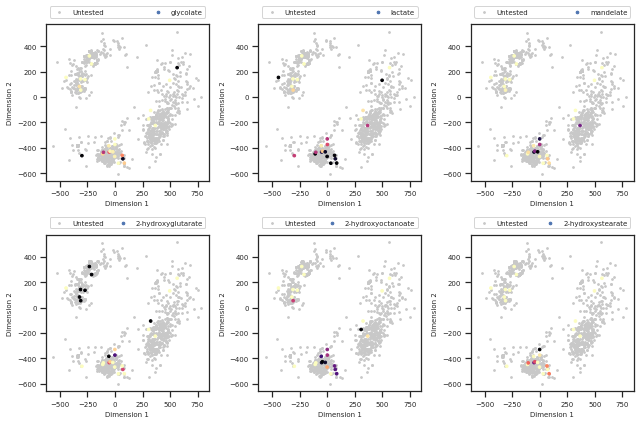

In [12]:
data = drop_columns(df_unirep)

mds = MDS(n_components=2, 
          random_state=42).fit_transform(data)

plot_substrate_activity(plot=mds, data=ml_data)

#### Make histograms of the distribution of training data values

#### Train model using cross-validation

20-fold cross validation of GP regression model
R = 0.41


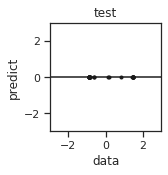

In [42]:
import GP_tools as GP
path_outputs = './outputs/'
property_ = 'glycolate'

def cross_validation(X, log_data, title, splits=20):
    '''
    X - features used for training
    log_data - the values I want to predict
    title - the title for the plot
    '''
    kf = KFold(n_splits=splits) # Define the split
    kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

    mu_s = []
    var_s = []
    y_s = []
    prams_test2 = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]

        log_data_train, log_data_test = log_data[train_index], log_data[test_index]

        y_train = (log_data_train - np.mean(log_data_train))/np.std(log_data_train)
        y_test = (log_data_test - np.mean(log_data_train))/np.std(log_data_train)

        initial_guess = [0.1, 10]

        # take the log of the initial guess for optimiziation 
        initial_guess_log = np.log(initial_guess)

        # optimize to fit model
        result = scipy.optimize.minimize(GP.neg_log_marg_likelihood, initial_guess_log, args=(X_train,y_train), method='L-BFGS-B')#,

        # next set of hyper prams 
        prams_me = [np.exp(result.x[0])**2, np.exp(result.x[1])]

        # next used trained GP model to predict on test data
        mu, var = GP.predict_GP(X_train, y_train, X_test, prams_me)
        mu_s.append(mu)
        var_s.append(var)
        y_s.append(y_test)

    # reformat all
    y_s_all = [j for i in y_s for j in i]
    mu_s_all = [j for i in mu_s for j in i]

    # calc correlation 
    measured = y_s_all
    predicted = mu_s_all

    par = np.polyfit(measured, predicted, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]

    # calc correlation 
    variance = np.var(predicted)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(measured, predicted)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    
    print('%s-fold cross validation of GP regression model' % splits)
    #print('R^2 = %0.2f'% Rsqr)
    print('R = %0.2f'% np.sqrt(Rsqr))

    # plot results
    plt.figure('My GP test set evaluation2', figsize=(2, 2))
    plt.title(str(title))
    plt.plot(y_s_all, mu_s_all, 'o', color='k', ms=3)
    plt.ylim([-3, 3])
    plt.ylabel('predict')
    plt.xlim([-3, 3])
    plt.xlabel('data')
    
    plt.plot([-3, 3], [slope*-3+intercept, slope*3+intercept], '-', color='k')
    plt.savefig(path_outputs + str(property_)+'_matern_kernel_CV.pdf', bbox_inches='tight', transparent=True)
    plt.show()
    return


in_data = ml_data[ml_data.glycolate >=0]
cross_validation(X=drop_columns(in_data, as_matrix=True), 
                 log_data=preprocessing.minmax_scale(in_data['2-hydroxyglutarate'].values, 
                                feature_range=(-1, 1), 
                                axis=0, 
                                copy=True), 
                 title='test')


#### Load the lactate oxidase data

In [141]:
# load up the "lactate odixase" experimental data 
lox_data = pd.read_csv(join(FINAL, 'experiments', 'lactate_ox_data.tsv'), sep='\t')


# remove proteins that were control
lox_data = lox_data[~lox_data.uid.isin(['A9QH69', 'C4VMW0', 'D4MUV9', 
                                        'control_BSA', 'patent_seq_mut'])]

# sort rows in the same order as the unirep data
lox_data['sort_cat'] = pd.Categorical(lox_data['uid'], 
                                          categories=df_unirep.uid, 
                                          ordered=True)
lox_data.sort_values('sort_cat', inplace=True)
lox_data.reset_index(inplace=True)
lox_data.drop(['index', 'sort_cat'], axis=1, inplace=True)

# drop constructs with no data
lox_data = lox_data[~lox_data.uid.isin(['A0A140L8U4', 'A0A161QAI9', 'A0A0S3QVA7', 'Q72LD0'])]

# re-order columns
cols = ['uid', '2-hydroxyglutarate' ,
        'glycolate', 'lactate',
        'mandelate', '2-hydroxyoctanoate',
        '2-hydroxystearate']
lox_data = lox_data[cols]
display(lox_data)

# re-scale data to the maximum value and convert to array
# experiment_vals = preprocessing.minmax_scale(lox_data.drop('uid', axis=1), 
#                                 feature_range=(0, 1), 
#                                 axis=1, 
#                                 copy=True)

# experiment_vals
lox_data.index = lox_data.uid
lox_data.drop('uid', axis=1, inplace=True)

lox_data = lox_data.div(lox_data.max(axis=1), axis=0)
display(lox_data)

,uid,2-hydroxyglutarate,glycolate,lactate,mandelate,2-hydroxyoctanoate,2-hydroxystearate
0,A0A075WBB5,0,0.000000,6.002818,0.000000,0.000000,0.000000
3,H6QAW2,0,0.140301,0.000000,0.000000,0.000000,0.021988
4,Q72G82,0,0.000000,0.000000,0.111981,10.710514,0.000000
5,A0A0F7IHH0,0,0.000000,0.320748,0.000000,1.383962,0.000000


,2-hydroxyglutarate,glycolate,lactate,mandelate,2-hydroxyoctanoate,2-hydroxystearate
uid,,,,,,
A0A075WBB5,0.0,0.0,1.000000,0.000000,0.0,0.00000
H6QAW2,0.0,1.0,0.000000,0.000000,0.0,0.15672
Q72G82,0.0,0.0,0.000000,0.010455,1.0,0.00000
A0A0F7IHH0,0.0,0.0,0.231761,0.000000,1.0,0.00000


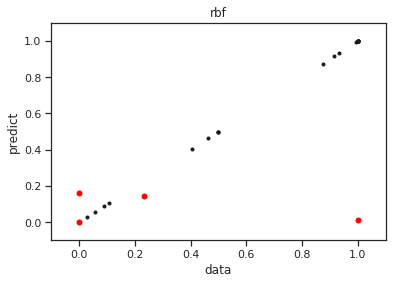

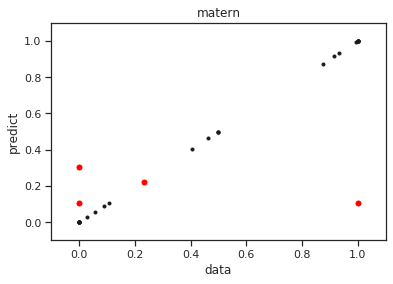

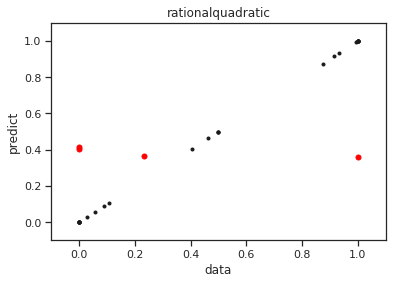

LinAlgError: ("The kernel, DotProduct(sigma_0=1), is not returning a positive definite matrix. Try gradually increasing the 'alpha' parameter of your GaussianProcessRegressor estimator.", '20-th leading minor of the array is not positive definite')

In [228]:
from sklearn.gaussian_process import GaussianProcessRegressor


substrate = 'lactate'

in_data = ml_data[ml_data[substrate] >=0]


#X = drop_columns(in_data, as_matrix=False)
X = pca[ml_data[substrate] >=0]
y = in_data[substrate].values

#test_data = ml_data[ml_data.uid.isin(['A0A075WBB5', 'H6QAW2', 'Q72G82', 'A0A0F7IHH0'])]
#X_test = drop_columns(test_data, as_matrix=False)
X_test = pca[ml_data.uid.isin(['A0A075WBB5', 'H6QAW2', 'Q72G82', 'A0A0F7IHH0'])]
y_test = lox_data[substrate].values

# #normalize columns
# min_max_scaler = preprocessing.MinMaxScaler()
# X = min_max_scaler.fit_transform(X)

# min_max_scaler = preprocessing.MinMaxScaler()
# X_test = min_max_scaler.fit_transform(X_test)

# RBF, Matern, RationalQuadratic, DotProduct, Exponentiation
# 
for k in ['rbf', 'matern', 'rationalquadratic', 'dotproduct', 'exponentiation']:
    if k == 'rbf':
        kernel = RBF()
    elif k == 'matern':
        kernel = Matern()
    elif k == 'rationalquadratic':
        kernel = RationalQuadratic()
    elif k == 'dotproduct':
        kernel = DotProduct(sigma_0=1)
    elif k == 'exponentiation':
        kernel = Exponentiation(DotProduct(), 3)
    else:
        raise ValueError
        
    gpr = GaussianProcessRegressor(kernel=kernel, 
                             alpha=1e-10, 
                             optimizer='fmin_l_bfgs_b', 
                             n_restarts_optimizer=10, 
                             normalize_y=False, 
                             copy_X_train=True, 
                             random_state=None).fit(X, y)


    #gpr.score(X, y)
                    
    # predict on training data
    y_mean, y_std = gpr.predict(X, return_std=True)

                    
    # predict on test data
    y_mean_test, y_std_test = gpr.predict(X_test, return_std=True)
    
    plt.title(k)
    plt.plot(y, y_mean, 'o', color='k', ms=3)
    plt.plot(y_test, y_mean_test, 'o', color='red', ms=5)
    plt.ylim([-0.1, 1.1])
    plt.ylabel('predict')
    plt.xlim([-0.1, 1.1])
    plt.xlabel('data')
    
    #plt.plot([-3, 3], [slope*-3+intercept, slope*3+intercept], '-', color='k')
    #plt.savefig(path_outputs + str(property_)+'_matern_kernel_CV.pdf', bbox_inches='tight', transparent=True)
    plt.show()



In [212]:
y_test
y_mean_test

array([0.18678312, 0.51088699, 0.77696792, 0.56806928])

Define helper functions for the gaussian classifier

In [16]:

def normalize_data_global(df):
    '''
    Globally normalizes values between 0 and 1
    '''
    max_a = df.max()
    min_a = df.min()
    min_norm = 0
    max_norm = 1
    df_norm = df.apply(lambda x : (x - min_a) *(max_norm - min_norm) / (max_a - min_a) + min_norm)
    
    #df_norm[df_norm < 0] = 0
    return df_norm


def normalize_data_columnwise(df):
    '''
    Performs column-wise normalization of data.
    '''
    # save the uid to use as index
    uid_index = df.index
    
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    
    # make into a data frame again with uid as an index
    df_scaled = pd.DataFrame(x_scaled, index=uid_index)
    
    return df_scaled


        


def plot_heatmap(truth, pred, classes, observations, title):
    '''
    Convenience function for plotting ground truth class belonings and predictions.
    '''
    x_labels = classes
    y_labels = observations
    
    fig, (ax1, ax2) = plt.subplots(1, 2)

   
    # make the heatmap
    img = ax1.imshow(truth,
                     interpolation='nearest',
                     cmap = 'magma_r',
                    vmin=0,
                    vmax=1) 

    # add tick labels
    ax1.set_xticks(range(0, len(x_labels)))
    ax1.set_yticks(range(0, len(y_labels)))

    ax1.set_xticklabels(labels=x_labels, rotation=45, ha='right')
    ax1.set_yticklabels(labels=y_labels)
    ax1.set_title('Truth')

    plt.xticks(fontsize=font_size+2)
    plt.yticks(fontsize=font_size+2)

    
    ## second heatmap ##
    img2 = ax2.imshow(pred,
                 interpolation='nearest',
                 cmap = 'magma_r',
                vmin=0,
                vmax=1) 

    # add tick labels
    ax2.set_xticks(range(0, len(x_labels)))
    ax2.set_yticks(range(0, len(y_labels)))

    ax2.set_xticklabels(labels=x_labels, rotation=45, ha='right')
    ax2.set_yticklabels(labels=y_labels)
    ax2.set_title('Prediction')

    plt.xticks(fontsize=font_size+2)
    plt.yticks(fontsize=font_size+2)
    
    # make a color bar
    cbar = plt.colorbar(img2)
    cbar.ax.tick_params(labelsize=font_size+2) 

    # set color bar label
    cbar.ax.get_yaxis().labelpad = 15
    cbar.set_label('Probability', rotation=270, fontsize=font_size+2)


    
    plt.show()

    

def plot_scatter(data, classes, glob_title):
    '''
    Convenience function for plotting the entire 1.1.3.15 dataset predictions on a scatterplot.
    Inputs:
    data - an array with prediction scores for each sequence and class
    classes - a list indicating with class labels corresponding to columns in the data
    '''
    assert  len(data[0]) == len(classes), 'Incorrect number of classes, must correspond to column number'
    
    # make a plotplot_scatter
    font_size = 7
    
    fig = plt.figure(figsize=(9, 6)) 
    fig.text(0.5,1.05, glob_title, horizontalalignment='center',
       verticalalignment='top')
    
    for i, cl in enumerate(classes):  

        plt.subplot(2, 3,i+1)

        # get predictions for this class
        pi = data[:, i]
        
        sc = plt.scatter(mds[:,0], mds[:,1],
                s=5, 
                c=pi,
                cmap='magma_r', # low contrast: 'viridis' 'plasma' high contrast: 'inferno' 'magma'
                vmin=0,
                vmax=1)

        plt.title(cl, fontsize=font_size+2)
        plt.xlabel('Dimension 1', fontsize=font_size)
        plt.ylabel('Dimension 2', fontsize=font_size)

        cb = fig.colorbar(sc)
        cb.ax.tick_params(labelsize=font_size) 
        plt.tick_params(labelsize=font_size)
    
    plt.tight_layout()

    
    
def get_x_y(df):
    '''
    Takes a data frame and returns only the features and class labels.
    Many assumptions have been made regarding which column names might occur.
    Input:
    A data frame (must have class labels in a column called "label")
    Output:
    X - a numpy array of features
    y - a series of class labels
    '''
    # separate into fatures and labels
    y = df.label
    X = drop_columns(df)
       
    return X, y
        

    
class MyGPC(object):
    '''
    A gaussian process modeling classifier.
    '''
    def __init__(self, kernel, normalize=True):
        self.kernel = kernel
        self.normalize = normalize
        
    
    def fit(self, X, y):
        '''
        Fit one GPmodel to each subclass according to one-vs-all
        '''
        self._X_train = X
        self._y_train = y
        self._classes = sorted(list(set(self._y_train)))
        
        self._clfs = []
        self._hypers = []
        self._ml = []
        for cl in self.class_order():
            clf = gpmodel.GPClassifier(self.kernel, guesses=None)
            
            # recode the y classes here to fit one vs all
            y_train_binear = np.array([1 if s == cl else -1 for s in self._y_train])
            
            clf.fit(self._X_train, y_train_binear)
            
            self._clfs.append(clf)
            self._hypers.append(clf.hypers)
            self._ml.append(clf.ML)
            
        
#     def save(self, filepath):
#         '''
#         save the model to disk
#         '''
#         self.clf.dump(filepath)

    
    def _run_prediction(self):
        '''
        '''
        all_pi = []
        all_mu = []
        all_var = []

        for clf in self._clfs:
            # predict on the test dataset
            pi, mu, var = clf.predict(self._X_test) 
            var = np.diag(var)

           
            # add prediction to out data
            all_pi.append(pi)
            all_mu.append(mu)
            all_var.append(var)
           
        pi_raw = np.array(list(zip(*all_pi)))
        mu_raw = np.array(list(zip(*all_mu)))
        var_raw = np.array(list(zip(*all_var)))

        # normalize values here to that the probabilities for each observation sum to 1
        pi_norm = []
        if self.normalize is True:
            for observation in pi_raw:
                pi_norm.append(observation/sum(observation))
        else:
            for observation in pi_raw:
                pi_norm.append(observation)            
            
        self.pi = np.array(pi_norm)
        self.mu = mu_raw
        self.var = var_raw
        
        # get the final prediction of categories
        self.y_pred = []
        for observation in self.pi:
            # find which class has maximum probability
            probs = list(observation)
            ind = probs.index(max(probs))
            
            # find the appropriate label for that class
            self.y_pred.append(self._classes[ind])
        
        
    def predict(self, X):
        '''
        predict on the test dataset
        '''
        self._X_test = X
        self._run_prediction()
        
        return self.y_pred

    
    def predict_proba(self, X):
        '''
        get prediction probablities for the test dataset
        '''
        self._X_test = X
        self._run_prediction()
        
        return self.pi

    
    def class_order(self):
        '''
        Return the order of the classes (predictors)
        '''
        return self._classes
    
    
    
def leave_one_out_evaluation(X, y, kernel):
    '''
    '''
    print('LEAVE-ONE-OUT CROSS-VALIDATION')
    
    # first I want to run the full dataset, only for the purpose of getting the class order
    gpc = MyGPC(kernel=kernel)
    gpc.fit(X, y)
    class_order = gpc.class_order()
    
    # now do leave-one-out
    loo = LeaveOneOut()
    y_pred_class = []
    y_pred_prob = None
    for train, test in loo.split(X):
        #print("%s %s" % (train, test))
        
        X_train = X[np.array(train)]
        y_train = y.iloc[train]

        X_test = X[np.array(test)]
        
        # train model
        gpc = MyGPC(kernel=kernel)
        gpc.fit(X_train, y_train)

        # predict label on the one left out
        lab = gpc.predict(X_test)
        y_pred_class.append(lab)
        
        # get the probabilities
        prob = gpc.predict_proba(X_test)
        
        # if there is only one example it is problematic when it ends up as the test observation
        # for this reason zero is inserted there
        if len(set(y_train)) != len(set(y)):
            # get the index of the missing class
            missing_label = list(set(y) - set(y_train))[0]
            missing_label_index = class_order.index(missing_label)
            
            # now insert nan at that index
            prob = np.insert(prob, missing_label_index, 0, axis=1)
        
        if y_pred_prob is None:
            y_pred_prob = prob
        else:
            y_pred_prob = np.append(y_pred_prob, prob, axis=0) 
        
    return y_pred_prob, y_pred_class, class_order
        
       
        
def predict_on_all(X, y, X_test, kernel):
    '''
    Predicts weighted probabilities for all classes on all sequences.
    Essentially checks which is most likely given the different models.
    '''
    print('FULL MODEL FIVE CLASSES')

    ## train full model and predict best class for all ##
    gpc = MyGPC(kernel=kernel, normalize=True)
    gpc.fit(X, y)

    prob = gpc.predict_proba(X_test)

    plot_scatter(prob, gpc.class_order(), 'Normalized probabilities')
    
 
    ## train full model on the three classes with one sequence and predict probability for all ##
    gpc = MyGPC(kernel=kernel, normalize=False)
    gpc.fit(X, y)

    prob = gpc.predict_proba(X_test)

    plot_scatter(prob, gpc.class_order(), 'Unnormalized probabilities')



        
def evaluate(all_data, kernel):
    '''
    '''
    # get only data that has a class label
    train_data = all_data[~all_data.label.isnull()]
    
    # convert to feature matrix and list of labels
    X, y = get_x_y(train_data)

    # leave-one-out evaluation
    y_prob, y_pred, class_order = leave_one_out_evaluation(X, y, kernel)

    # visualize the ground truth
    plot_heatmap(truth=preprocessing.label_binarize(y, classes=class_order), 
                 pred=y_prob,
                 classes=class_order,
                 observations=train_data.uid, 
                 title='Truth')


    # confusion matrix
    #print(metrics.confusion_matrix(y, y_pred))

    # evaluate recall and precision
    print(metrics.classification_report(y, y_pred, digits=3))

    ## train full model and predict on all
    X_test, _ = get_x_y(all_data)
    predict_on_all(X, y, X_test, kernel)


## choose kernel ##
#kernel = gpkernel.LinearKernel() #
#kernel = gpkernel.MaternKernel('5/2')
#kernel = gpkernel.MaternKernel('3/2')
#kernel = gpkernel.PolynomialKernel(2) #
#kernel = gpkernel.PolynomialKernel(3)
#kernel = gpkernel.PolynomialKernel(4)
#kernel = gpkernel.BaseRadialKernel(X1=, X2=) #requires additional arguments
#kernel = gpkernel.BaseRadialARDKernel(X1=, X2=) #requires additional arguments
#kernel = gpkernel.ARDMaternKernel('5/2')
#kernel = gpkernel.ARDMaternKernel('3/2')
#kernel = gpkernel.SEKernel()
#kernel = gpkernel.ARDSEKernel()

Classify using all pairwise identities

In [17]:
# load up the identity matrix data
df_ident = pd.read_csv(join(FINAL, 'BRENDA', 'all_identity_matrix_ident.tsv'), 
                       sep='\t', 
                      index_col=0)

# keep only identifiers that are in my property dataset
df_selected = df_ident.loc[prop_data.uid.values, prop_data.uid.values]

# normalize the column values
df_norm = df_selected#normalize_data_columnwise(df_selected)

# use protein name index as column
df_norm['uid'] = df_norm.index


# now merge with the property data
ml_data = prop_data.merge(df_norm, on='uid')

display(ml_data.head())
display(ml_data.tail())
display(ml_data.shape)

# test whether it is suitable for a classifier
evaluate(all_data=ml_data, kernel=gpkernel.LinearKernel())

NameError: name 'prop_data' is not defined

Classify using moran data

In [ ]:
# load data and drop duplicates
filepath = join(INTERMEDIATE, '1.1.3.n_test_data', 'Moran.tsv')
moran = pd.read_csv(filepath, sep='\t')

# replace the first column with identifiers
moran['#'] = [i.split(';')[0] for i in moran['#']]

# re-name column
df_moran = moran.rename(columns={'#':'uid'}).drop_duplicates()

# set uid as index
uid_index = df_moran.uid
df_moran = df_moran.drop('uid', axis=1)
df_moran.index = uid_index
del df_moran.index.name

# keep only identifiers that are in my property dataset
df_selected = df_moran.loc[prop_data.uid.values]

# normalize the column values
df_norm = df_selected#normalize_data_columnwise(df_selected)

# use protein name index as column
df_norm['uid'] = df_norm.index


# now merge with the property data
ml_data = prop_data.merge(df_norm, on='uid')

display(ml_data.head())
display(ml_data.tail())
display(ml_data.shape)

# test whether it is suitable for a classifier
evaluate(all_data=ml_data, kernel=gpkernel.LinearKernel())


Classify using ProtVec

In [ ]:
%%time

    
def load_data(filename):
    '''
    Load up the vector data
    '''
    data = {}
    with open(filename, 'r') as f:
        for line in f:
            elements = line.split('\t')
            
            if elements[0] == '<unk>':
                continue
            
            codon = elements[0]
                
            data[codon] = {}
                
            for num in range(1, 10):
                data[codon][num] = np.array([float(i)*num for i in elements[1:]])
                
    return data



def score_seq(seq, enbedding, to_int=True):
    '''
    Use the embedding to calculate a feature vector for a protein sequence.
    
    This is the fastest one. Gives a performance of about 4.2 hours for 10 mio sequences.
    '''
    seq = seq.upper()  
    
    # make all the three-mers
    three_mers = Counter([seq[i:i+3] for i in range(0, len(seq)-2)])
    
    # multiply the occurances with the feature vector
    c = [enbedding[k][v] for k, v in three_mers.items()]
    
    # sum the columns of the generated vectors
    vector_sums = np.array(c).sum(axis=0)
    
    # convert to int if desired
    if to_int is True:
        vector_sums = np.around(vector_sums * 1000)
    
    return vector_sums.tolist()
    
    
    
# load up the embedding data

filename = 'protVec_100d_3grams.tsv'
filepath = join(RAW_EXTERNAL, 'protvec', filename)
embedding = load_data(filepath) 

In [ ]:
%%time

def vectorize_fasta(filepath, to_int=False):
    '''
    Take a fasta file and return, in order the embedded sequence vectors.
    '''
    data = []
    for record in SeqIO.parse(filepath, format='fasta'):
        header, seq = record.description, record.seq
        
        data.append(score_seq(seq, embedding, to_int=to_int))

    return np.array(data), len(data)
        
    
    
def vectorize_fasta_list(filepath_list):
    '''
    Process a list of fasta files
    '''
    all_data = None
    seqs_per_file = []
    
    for filepath in filepath_list:
        fasta_data, fasta_len = vectorize_fasta(filepath)
        
        # how many seqs per file
        seqs_per_file.append(fasta_len)
        
        if all_data is None:
            all_data = np.array(fasta_data)
            
        else:
            all_data = np.concatenate((all_data, fasta_data), axis=0)
        
    print(len(all_data))
    return all_data, seqs_per_file
    

def get_header_info_from_fasta(filepath):
    '''
    Make a list of all the ec numbers and uniprot identifiers in a fasta file
    '''
    uid_list = []
    ec_list= []
    org_list = []
    source_list = []
    length_list = []
    sequences = []
      
    for record in SeqIO.parse(filepath, format='fasta'):
        header, seq = record.description, record.seq
        
        uid, name, ec, org, source, length, *_ = header.split(';')
        

        
        if uid in uid_list:
            print(uid, ec)
            continue
        
        uid_list.append(uid)
        ec_list.append(ec)
        org_list.append(org)
        source_list.append(source)
        length_list.append(length)
        sequences.append(str(seq).upper())
        
    return np.array(uid_list), np.array(ec_list), np.array(org_list), np.array(source_list), np.array(length_list), sequences






filepath = join(RAW_EXTERNAL, '1.1.3.n_test_data', '1_1_3__BRENDA_sequences_filtered.fasta')

uid_list, ec_list, org_list, source_list, length_list, sequences = get_header_info_from_fasta(filepath)

# get an array of the data in the fasta files

prot_embedding = np.array([score_seq(seq, embedding, to_int=False) for seq in sequences])

brenda = pd.DataFrame(prot_embedding)

brenda['uid'] = uid_list

In [ ]:
# set uid as index
uid_index = brenda.uid
brenda = brenda.drop('uid', axis=1)
brenda.index = uid_index
del brenda.index.name

# keep only identifiers that are in my property dataset
df_selected = brenda.loc[prop_data.uid.values]

# normalize the column values
df_norm = df_selected#normalize_data_columnwise(df_selected)

# use protein name index as column
df_norm['uid'] = df_norm.index


# now merge with the property data
ml_data = prop_data.merge(df_norm, on='uid')

display(ml_data.head())
display(ml_data.tail())
display(ml_data.shape)

# test whether it is suitable for a classifier
evaluate(all_data=ml_data, kernel=gpkernel.LinearKernel())


Classify using descriptors

In [ ]:
# load data and drop duplicates
filepath = join(INTERMEDIATE, '1.1.3.n_test_data', 'descriptors.tsv')
desc = pd.read_csv(filepath, sep='\t')

# replace the first column with identifiers
desc['#'] = [i.split(';')[0] for i in desc['#']]


# re-name column
df_desc = desc.rename(columns={'#':'uid'}).drop_duplicates()

# set uid as index
uid_index = df_desc.uid
df_desc = df_desc.drop('uid', axis=1)
df_desc.index = uid_index
del df_desc.index.name

# keep only identifiers that are in my property dataset
df_selected = df_desc.loc[prop_data.uid.values]

# normalize the column values
df_norm = df_selected#normalize_data_columnwise(df_selected)

# use protein name index as column
df_norm['uid'] = df_norm.index



# now merge with the property data
ml_data = prop_data.merge(df_norm, on='uid')

display(ml_data.head())
display(ml_data.tail())
display(ml_data.shape)

# test whether it is suitable for a classifier
evaluate(all_data=ml_data, kernel=gpkernel.LinearKernel())


Classify using UniRep Fusion

In [ ]:
# set uid as index
uid_index = df_unirep.uid
df_unirep_copy = df_unirep.drop('uid', axis=1)
df_unirep_copy.index = uid_index
del df_unirep_copy.index.name

# keep only identifiers that are in my property dataset
df_selected = df_unirep_copy.loc[prop_data.uid.values]

# normalize the column values
df_norm = df_selected#normalize_data_columnwise(df_selected)

# use protein name index as column
df_norm['uid'] = df_norm.index


# now merge with the property data
ml_data = prop_data.merge(df_norm, on='uid')


display(ml_data.head())
display(ml_data.tail())
display(ml_data.shape)

# test whether it is suitable for a classifier
evaluate(all_data=ml_data, kernel=gpkernel.LinearKernel())


Take a look at a few sequences that the model was not trained on

In [ ]:
others = ['A0A075WBB5',
'A0A0F7IHH0',
'A0A0S3QVA7',
'A0A140L8U4',
'A0A161QAI9',
'H6QAW2',
'Q72G82',
'Q72LD0']
#'A9QH69',
#'C4VMW0',
#'D4MUV9']

# check that they have not been evaluated in this batch
others_df = ml_data[ml_data.uid.isin(others)]
display(others_df)

# only keep instances with a class assigned to them
train_data = ml_data[~ml_data.label.isnull()]
    
# convert to feature matrix and list of labels
X, y = get_x_y(train_data)

gpc = MyGPC(kernel=gpkernel.LinearKernel(), normalize=True)
gpc.fit(X, y)

X_test, _ = get_x_y(others_df)
prob = gpc.predict_proba(X_test)
y_predict = gpc.predict(X_test)

display(prob)
display(y_predict)
display(others_df.uid)

In [ ]:
# load up the "lactate odixase" experimental data 
lox_data = pd.read_csv(join(FINAL, 'experiments', 'lactate_ox_data.tsv'), sep='\t')


# remove proteins that were control
lox_data = lox_data[~lox_data.uid.isin(['A9QH69', 'C4VMW0', 'D4MUV9', 
                                        'control_BSA', 'patent_seq_mut'])]

# sort rows in the same order as the unirep data
lox_data['sort_cat'] = pd.Categorical(lox_data['uid'], 
                                          categories=df_unirep.uid, 
                                          ordered=True)
lox_data.sort_values('sort_cat', inplace=True)
lox_data.reset_index(inplace=True)
lox_data.drop(['index', 'sort_cat'], axis=1, inplace=True)

# drop constructs with no data
lox_data = lox_data[~lox_data.uid.isin(['A0A140L8U4', 'A0A161QAI9', 'A0A0S3QVA7'])]

# re-order columns
cols = ['uid', '2-hydroxyglutarate' ,
        'glycolate', 'lactate',
        'mandelate', '2-hydroxyoctanoate',
        '2-hydroxystearate']
lox_data = lox_data[cols]
display(lox_data)

# re-scale data to the maximum value and convert to array
experiment_vals = preprocessing.minmax_scale(lox_data.drop('uid', axis=1), 
                                feature_range=(0, 1), 
                                axis=1, 
                                copy=True)


## Plot heatmaps ##

fig, (ax1, ax2) = plt.subplots(1, 2)


# make the heatmap
img = ax1.imshow(experiment_vals,
                 interpolation='nearest',
                 cmap = 'magma_r',
                vmin=0,
                vmax=1) 

# add tick labels
x_labels = ['2-hydroxyglutarate' ,
            'glycolate', 'lactate',
            'mandelate', '2-hydroxyoctanoate',
            '2-hydroxystearate']
y_labels = lox_data.uid

ax1.set_xticks(range(0, len(x_labels)))
ax1.set_yticks(range(0, len(y_labels)))

ax1.set_xticklabels(labels=x_labels, rotation=45, ha='right')
ax1.set_yticklabels(labels=y_labels)
ax1.set_title('Truth')

plt.xticks(fontsize=font_size+2)
plt.yticks(fontsize=font_size+2)


## second heatmap ##
img2 = ax2.imshow(prob,
             interpolation='nearest',
             cmap = 'magma_r',
            vmin=0,
            vmax=1) 

# add tick labels
x_labels = gpc.class_order()
y_labels = others_df.uid

ax2.set_xticks(range(0, len(x_labels)))
ax2.set_yticks(range(0, len(y_labels)))

ax2.set_xticklabels(labels=x_labels, rotation=45, ha='right')
ax2.set_yticklabels(labels=y_labels)
ax2.set_title('Prediction')

plt.xticks(fontsize=font_size+2)
plt.yticks(fontsize=font_size+2)

# make a color bar
cbar = plt.colorbar(img2)
cbar.ax.tick_params(labelsize=font_size+2) 

# set color bar label
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('Probability', rotation=270, fontsize=font_size+2)

plt.tight_layout()

This prediction actually does not look terribly good... Maybe I should try to make gausian regression models instead. I'm loosing information by putting the sequences into classes.

## Try out GP method built into scikit-learn

In [ ]:
# X, y = get_x_y(ml_data[~ml_data.label.isnull()])

# # pick a kernel
# kernel = RationalQuadratic()
# #kernel = ExpSineSquared()

# # train the model
# gpc = GaussianProcessClassifier(kernel=kernel,
#          random_state=0, multi_class='one_vs_rest').fit(X, y)

# # # what's this ?? 
# # gpc.score(X, y) 

# # predict class belonging based on trained model
# prob = gpc.predict_proba(drop_columns(ml_data))

# plot_scatter(prob, gpc.class_order(), 'Normalized probabilities')



# now predict on entire dataset and visualize


In [ ]:

# fig = plt.figure(figsize=(9, 6))

# for i, subst in enumerate(substrates):

#     plt.subplot(2, 3,i+1)

#     plt.scatter(ident_result[ident_result.substrate==subst].pi, 
#                 unirep_result[ident_result.substrate==subst].pi,
#                 s=3)
#     plt.xticks(np.arange(0, 1, 0.1))
#     plt.yticks(np.arange(0, 1, 0.1))
#     plt.xlabel('identity', fontsize=font_size)
#     plt.ylabel('unirep', fontsize=font_size)
#     plt.title(subst, fontsize=font_size+2)
#     plt.tick_params(labelsize=font_size)

#     plt.plot([0, 0.9], [0, 0.9], c='gray')


    
# plt.tight_layout()

#### Do a classifier on a one-hot encoded multiple sequence alignment

In [ ]:
# # first shorten the headers, gblocks complains about them
# for fi in sorted(os.listdir(join(FINAL, 'BRENDA'))):
#     if fi.endswith('_alignment.fasta'):
#         alignment_path = join(FINAL, 'BRENDA', fi)

#         with open(join(FINAL, 'BRENDA', fi.replace('.fasta', '_short_header.fasta')), 'w') as f:

#             for record in SeqIO.parse(alignment_path, "fasta"):
#                 header = record.id.split(';')[0]
#                 seq = record.seq
#                 f.write('>%s\n%s\n\n' % (header, seq))
                
                
# # now run gblocks on them
# for fi in sorted(os.listdir(join(FINAL, 'BRENDA'))):
#     if fi.endswith('_short_header.fasta'):
#         alignment_path = join(FINAL, 'BRENDA', fi)
        
#         mycmd = 'Gblocks %s -t=p -b4=2 -b5=A -b6=y -k=y' % alignment_path
#         os.system(mycmd)
        

# # combine all the cleaned sequences and remove gaps
# all_aln_path = join(FINAL, 'BRENDA', 'all_clusters_shortened.fasta')
# with open(all_aln_path, 'w') as f:
#     for fi in sorted(os.listdir(join(FINAL, 'BRENDA'))):
#         if fi.endswith('_short_header.fasta-gb'):
#             alignment_path = join(FINAL, 'BRENDA', fi)

#             for record in SeqIO.parse(alignment_path, "fasta"):
#                 header = record.id
#                 seq = str(record.seq).replace('-', '')
                
#                 f.write('>%s\n%s\n\n' % (header, seq))                

# # align all cleaned sequences against each other
# infile = all_aln_path
# outfile = all_aln_path.replace('.fasta', 'aln.fasta')
# mycmd = 'muscle -in %s -out %s -quiet' % (infile, outfile)
# os.system(mycmd)


In [ ]:
# from Bio.Alphabet import IUPAC



# def one_hot_code_of_single_aa(num_fmt='bool_'):
#     # return a dictionary which contains one-hot codes for 20 amino acids
#     # each one-hot is a list
#     #

#     aas = IUPAC.IUPACProtein.letters

#     codes = dict()

#     L = len(aas)

#     for i in range(L):
#         aa = aas[i]
#         code = np.zeros(L, dtype=num_fmt) #[0 for i in range(L)]
#         code[i] = 1
#         codes[aa] = code

#     codes['-'] = np.zeros(L, dtype=num_fmt)
#     codes['X'] = np.zeros(L, dtype=num_fmt)

#     return codes



# def one_hot_seq_new(seq_input, mode='identity'):
#     '''
#     One-hot encode a set of protein sequences
#     '''
#     assert mode in ['identity', 'property', 'embedding'], 'Error, the argument "mode" must be one of "identity", "property" or "embedding"'

#     if mode == 'identity':
#         codes = one_hot_code_of_single_aa()

#     elif mode == 'property':
#         codes = one_hot_aa_property()

#     elif mode == 'embedding':
#         raise NotImplementedError


#     X = []

#     # loop through each sequence and one_hot encode
#     for seq in seq_input: # for each sequence

#         # go through each amino acid and get the appropriate bits
#         x = list()
#         for aa in seq:
#             x.append(codes.get(aa, codes['X']))

#         X.append(np.array(x).ravel())

#     return np.array(X)



# # collect all the sequences
# headers = []
# short_seqs = []
# for record in SeqIO.parse(outfile, "fasta"):
#     header = record.id
#     seq = str(record.seq).replace('-', '')

#     headers.append(header)
#     short_seqs.append(seq)

    
# encoded_seqs = one_hot_seq_new(short_seqs)